In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Data Merging

In [ ]:
info = pd.read_csv("data/inverse/info.csv")
ccba = pd.read_csv("data/inverse/ccba.csv")
cdtx = pd.read_csv("data/inverse/cdtx.csv")
dp = pd.read_csv("data/inverse/dp.csv")
remit = pd.read_csv("data/inverse/remit.csv")

In [ ]:
# 合併info & ccba
info["month"] = info["date"].apply(lambda X: X[:7])
ccba["month"] = ccba["byymm"].apply(lambda X: X[:7])
info = pd.merge(info, ccba, on = ["cust_id", "month"], how = "left")
info = info.drop(["month", "byymm"], axis = 1)
info.head()

In [ ]:
# 刪除沒有日期的交易
cdtx = cdtx[~cdtx["date"].isnull()].reset_index(drop = True)
dp = dp[~dp["tx_date"].isnull()].reset_index(drop = True)

In [ ]:
# 統一日期名稱
dp = dp.rename(columns = {"tx_date": "date"})
remit = remit.rename(columns = {"trans_date": "date"})

In [ ]:
# info data與各類型的交易各自合併
info1 = pd.merge(info, cdtx, on = ["date", "cust_id"], how = "inner")
info2 = pd.merge(info, dp, on = ["date", "cust_id"], how = "inner")
info3 = pd.merge(info, remit, on = ["date", "cust_id"], how = "inner")

print(len(info1), len(info2), len(info3))

In [ ]:
# 合併各類型資料
trade = pd.concat([info1, info2, info3], ignore_index = True)
print(trade.shape)

In [ ]:
# 查看合併後的資料是否還有沒有交易的情況
trade[trade.iloc[:, 16:].isnull().all(axis = 1)]

In [ ]:
# 抓出已有交易資料的alert_key
alert_key = trade["alert_key"].unique()
print(trade["alert_key"].nunique())
alert_key

In [ ]:
# 抓出當天沒有交易資料的sample
no_trade = info.query("alert_key not in @alert_key").copy()
no_trade

In [ ]:
# 查看alert_key長度是否相符
len(no_trade) + len(alert_key) == len(info)

In [ ]:
# 抓出該alert_key日期之前的最後一筆交易日期
def get_last_date(datas, date, cust_id):
    last_date = []
    for d in datas: # 逐資料源確認最後日期
        trades = d.query("(cust_id == @cust_id) & (date < @date)") # 該alert_key日期之前的samples
        if len(trades) > 0:
            end_date = trades.iloc[-1]["date"] # 抓出最後一筆交易日期
            last_date.append(end_date)
    if last_date:
        return max(last_date) # 回傳最晚的日期
    else:
        return None

In [ ]:
no_trade["last_date"] = None
datas = [cdtx, dp, remit]
no_trade_num = 0
with tqdm(total = len(no_trade), ncols = 200) as _tqdm:
    for i in range(len(no_trade)):
        date = no_trade.iloc[i]["date"]
        cust_id = no_trade.iloc[i]["cust_id"]
        no_trade.iloc[i, -1] = get_last_date(datas, date, cust_id) # 抓出該alert_key日期之前的最後一筆交易日期

        if no_trade.iloc[i, -1] == None: # 沒有交易資料的sample數量
            no_trade_num += 1
        
        _tqdm.set_postfix({"no_trade_num" : no_trade_num})# 設置想在本次循環監視變量，可作後綴打印出來
        _tqdm.update(1)

# no_trade.to_csv("data/temp.csv", index = False)

In [ ]:
# 查看沒有交易資料的sample數量
no_trade["last_date"].isnull().sum()

In [ ]:
# no_trade與各類型的交易各自合併
no_trade1 = pd.merge(no_trade, cdtx, left_on = ["cust_id", "last_date"], right_on = ["cust_id", "date"], how = "inner")
no_trade2 = pd.merge(no_trade, dp, left_on = ["cust_id", "last_date"], right_on = ["cust_id", "date"], how = "inner")
no_trade3 = pd.merge(no_trade, remit, left_on = ["cust_id", "last_date"], right_on = ["cust_id", "date"], how = "inner")

print(len(no_trade1), len(no_trade2), len(no_trade3))

In [ ]:
# 合併各類型資料
trade1 = pd.concat([no_trade1, no_trade2, no_trade3], ignore_index = True)
print(trade1.shape)

In [ ]:
# 查看合併後的資料是否還有沒有交易的情況
trade1[trade1.iloc[:, 17:].isnull().all(axis = 1)]

In [ ]:
# 查看alert_key長度是否相符
# 當天有資料的alert_key數量 + 當天之前有資料的alert_key數量 + 沒有交易資料的alert_key數量 == 總alert_key數量
trade["alert_key"].nunique() + trade1["alert_key"].nunique() + 1936 == len(info)

In [ ]:
# 統一 feature名稱
trade1 = trade1.drop(["last_date", "date_y"], axis = 1)
trade1 = trade1.rename(columns = {"date_x": "date"})

In [ ]:
# 合併 當天有交易資料 和 當天之前有交易資料 的sample
print(len(trade), len(trade1)) 
trade = pd.concat([trade, trade1], ignore_index = True)
print(len(trade))

In [ ]:
# 抓出已有交易資料的alert_key
alert_key = trade["alert_key"].unique()
print(trade["alert_key"].nunique())
alert_key

In [ ]:
# 抓出當天沒有交易資料的sample
no_trade = info.query("alert_key not in @alert_key").copy()
no_trade

In [ ]:
# 合併 有交易資料 和 沒交易資料 的sample
df = pd.concat([trade, no_trade])
df = df.sort_values(["alert_key", "tx_time"]).reset_index(drop = True)
len(df)

In [ ]:
# 查看alert_key長度是否相符
df["alert_key"].nunique() == len(info)

In [ ]:
# 查看沒交易資料的sample數
df.iloc[:, 16:].isnull().all(axis = 1).sum()

In [ ]:
df.to_csv("data/inverse/all.csv", index = False)

## Data Processing

In [2]:
df = pd.read_csv("data/inverse/all.csv")
print(df.shape)
df.head(3)

(246926, 31)


,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,tx_type,tx_amt,exchg_rate,info_asset_code,fiscTxId,txbranch,cross_bank,ATM,trans_no,trade_amount_usd
0,171142,2021-04-01,0.0,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,12565.0,150744.0,...,2.0,7035.0,1.0,13.0,4.0,0.0,0.0,1.0,NaN,NaN
1,171142,2021-04-01,0.0,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,12565.0,150744.0,...,2.0,4556.0,1.0,1.0,NaN,NaN,0.0,1.0,NaN,NaN
2,171142,2021-04-01,0.0,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,12565.0,150744.0,...,2.0,7355.0,1.0,1.0,NaN,NaN,0.0,1.0,NaN,NaN


In [3]:
target = "sar_flag"

In [4]:
print(f'0/1: {len(df) / df[target].sum()}')
df[target].value_counts()

0/1: 77.40626959247649


0.0    226751
1.0      3190
Name: sar_flag, dtype: int64

In [5]:
df["alert_key"].nunique()

25751

In [6]:
print("start missing value:", df["occupation_code"].isnull().sum())

occu = df[~df["occupation_code"].isnull()] # 有職業資料的cust_id
occu_map = occu[["cust_id", "occupation_code"]].drop_duplicates() # 每個cust_id所對應的職業
occu_map = occu_map.drop_duplicates(subset = ['cust_id'], keep = "last") # cust_id所對應的職業，抓出最新資料 (cust_id有可能轉職)

# Dataframe to dict
occu_map = occu_map.set_index("cust_id")
occu_map = occu_map["occupation_code"].to_dict()

df["occupation_code"] = df["cust_id"].map(occu_map) # 填補缺失值

print("end missing value:", df["occupation_code"].isnull().sum())

start missing value: 345
end missing value: 268


In [7]:
# cust_id轉換為數值；occupation_code缺失值處理，直接新增一個缺失類別
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
feats = ["cust_id", "occupation_code"]
for feat in feats:
    df[feat] = le.fit_transform(df[feat])
df.head(3)

,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,tx_type,tx_amt,exchg_rate,info_asset_code,fiscTxId,txbranch,cross_bank,ATM,trans_no,trade_amount_usd
0,171142,2021-04-01,0.0,4962,3,12,241719.0,3,12565.0,150744.0,...,2.0,7035.0,1.0,13.0,4.0,0.0,0.0,1.0,NaN,NaN
1,171142,2021-04-01,0.0,4962,3,12,241719.0,3,12565.0,150744.0,...,2.0,4556.0,1.0,1.0,NaN,NaN,0.0,1.0,NaN,NaN
2,171142,2021-04-01,0.0,4962,3,12,241719.0,3,12565.0,150744.0,...,2.0,7355.0,1.0,1.0,NaN,NaN,0.0,1.0,NaN,NaN


In [8]:
df["debit_credit"] = df["debit_credit"].map({"DB": 1, "CR": -1}) # debit借(存)以1取代；credit貸(提)以-1取代

df["tx_amt"] = df.eval("tx_amt * exchg_rate") # 匯率換算(台幣)
df = df.drop("exchg_rate", axis = 1)

df["tx_time"] = pd.to_datetime(df["tx_time"]).dt.hour

In [9]:
# cyclical feature encoding

df["date"] = pd.to_datetime(df["date"])

df['month'] = df["date"].dt.month
df['day'] = df["date"].dt.day

df['month_sin'] = np.sin(2 * np.pi *  df['month']/ 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

df['hour_sin'] = np.sin(2 * np.pi * df['tx_time'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['tx_time'] / 24)

df = df.drop(["month", "day", "tx_time"], axis = 1)

In [10]:
# 各份資料的缺失值檢查
cdtx = df.iloc[:, [2, 16, 17, 18]]
dp = df.iloc[:, [2, 19, 20, 21, 22, 23, 24, 25, 26]]
remit = df.iloc[:, [2, 27, 28]]


cdtx = cdtx[~ cdtx.iloc[:, 1:].isnull().all(axis = 1)]
dp = dp[~ dp.iloc[:, 1:].isnull().all(axis = 1)]
remit = remit[~ remit.iloc[:, 1:].isnull().all(axis = 1)]

print("missing value of cdtx: ", cdtx.iloc[:, 1:].isnull().sum().sum())
print("missing value of dp: ", dp.iloc[:, 1:].isnull().sum().sum())
print("missing value of remit: ", remit.iloc[:, 1:].isnull().sum().sum())

missing value of cdtx:  0
missing value of dp:  189215
missing value of remit:  0


In [11]:
# 若dp有缺失值，且sar_flag = 0，則刪除該dp資料
dp = df.loc[:, "debit_credit":"ATM"]
dp = dp[~ dp["debit_credit"].isnull()]

df_dp = df.iloc[dp.index]
df_dp["miss"] = dp.isnull().any(axis = 1).astype(int)
df_null = df_dp.query("(sar_flag == 0) & (miss == 1)")
df.loc[df_null.index, "debit_credit":"ATM"] = None
df = df.drop_duplicates()

print(df.shape)
df.head(3)

(151854, 35)


,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,cross_bank,ATM,trans_no,trade_amount_usd,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,171142,2021-04-01,0.0,4962,3,12,241719.0,3,12565.0,150744.0,...,0.0,1.0,NaN,NaN,0.866025,-0.5,0.201299,0.97953,-0.500000,-0.866025
1,171142,2021-04-01,0.0,4962,3,12,241719.0,3,12565.0,150744.0,...,NaN,NaN,NaN,NaN,0.866025,-0.5,0.201299,0.97953,-0.866025,-0.500000
4,171142,2021-04-01,0.0,4962,3,12,241719.0,3,12565.0,150744.0,...,1.0,1.0,NaN,NaN,0.866025,-0.5,0.201299,0.97953,-0.965926,-0.258819


In [12]:
dp = df.loc[:, "debit_credit":"ATM"]
dp = dp[~ dp["debit_credit"].isnull()]
dp.isnull().sum()

debit_credit          0
tx_type               0
tx_amt               67
info_asset_code       0
fiscTxId           7700
txbranch           7091
cross_bank            0
ATM                   0
dtype: int64

In [13]:
# 資料源內本身的缺失值處理，直接新增一個缺失類別
feats = ["fiscTxId", "txbranch"]
for feat in feats:
    dp[feat] = le.fit_transform(dp[feat])

dp["tx_amt"] = dp["tx_amt"].fillna(1) # 假設所有交易金額至少都有1元，缺失值補1
dp["tx_amt"] = dp["tx_amt"].replace(0, 1) # 假設所有交易金額至少都有1元，0以1取代

df.loc[dp.index, "debit_credit": "ATM"] = dp

In [14]:
# 各份資料的缺失值檢查
cdtx = df.iloc[:, [2, 16, 17, 18]]
dp = df.iloc[:, [2, 19, 20, 21, 22, 23, 24, 25, 26]]
remit = df.iloc[:, [2, 27, 28]]


cdtx = cdtx[~ cdtx.iloc[:, 1:].isnull().all(axis = 1)]
dp = dp[~ dp.iloc[:, 1:].isnull().all(axis = 1)]
remit = remit[~ remit.iloc[:, 1:].isnull().all(axis = 1)]

print("missing value of cdtx: ", cdtx.iloc[:, 1:].isnull().sum().sum())
print("missing value of dp: ", dp.iloc[:, 1:].isnull().sum().sum())
print("missing value of remit: ", remit.iloc[:, 1:].isnull().sum().sum())

missing value of cdtx:  0
missing value of dp:  0
missing value of remit:  0


In [15]:
# 各份資料的類別轉換，Label encoding
import category_encoders as ce

cat_feats = [["risk_rank", "occupation_code", "AGE"], ["country", "cur_type"], ["tx_type", "info_asset_code", "fiscTxId", "txbranch", "cross_bank", "ATM"], ["trans_no"]]
datas = [df, cdtx, dp, remit]

for d, feats in zip(datas[1:], cat_feats[1:]):
    for feat in feats:
        d[feat] = le.fit_transform(d[feat])
        d[feat] += 1
    
    df.loc[d.index, feats] = d[feats]

#各份資料的類別轉換，Target encoding
import category_encoders as ce

cat_feats = [["risk_rank", "occupation_code", "AGE"], ["country", "cur_type"], ["tx_type", "info_asset_code", "fiscTxId", "txbranch", "cross_bank", "ATM"], ["trans_no"]]
datas = [df, cdtx, dp, remit]

for d, feats in zip(datas, cat_feats):
    train = d[~d[target].isnull()]
    test = d[d[target].isnull()]

    y_train = train.pop(target)
    test.pop(target)

    ce_target = ce.TargetEncoder(cols = feats)
    X_train = ce_target.fit_transform(train, y_train)
    X_test = ce_target.transform(test)

    df.loc[X_train.index, feats] = X_train[feats]
    df.loc[X_test.index, feats] = X_test[feats]

In [16]:
# 每個sample只會有一種交易，其他種類的交易填0
df.loc[:, "lupay":] = df.loc[:, "lupay":].fillna(0)

In [17]:
# flatten
cat_feats = sum(cat_feats, [])
cat_feats += ["debit_credit"]
cat_feats

['risk_rank',
 'occupation_code',
 'AGE',
 'country',
 'cur_type',
 'tx_type',
 'info_asset_code',
 'fiscTxId',
 'txbranch',
 'cross_bank',
 'ATM',
 'trans_no',
 'debit_credit']

In [18]:
df[cat_feats] = df[cat_feats].astype(int)

In [19]:
df.to_csv("data/inverse/all_process.csv", index = False)

## Data analyzing

In [2]:
df = pd.read_csv("data/inverse/all_process.csv")
print(df.shape)
print(f"alert_key: {df['alert_key'].nunique()}")
df.head(3)

(151854, 35)
alert_key: 25751


,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,lupay,cycam,...,cross_bank,ATM,trans_no,trade_amount_usd,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,171142,2021-04-01,0.0,4962,3,12,241719.0,3,12565.0,150744.0,...,1,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.500000,-0.866025
1,171142,2021-04-01,0.0,4962,3,12,241719.0,3,12565.0,150744.0,...,0,0,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.866025,-0.500000
2,171142,2021-04-01,0.0,4962,3,12,241719.0,3,12565.0,150744.0,...,2,2,0,0.0,0.866025,-0.5,0.201299,0.97953,-0.965926,-0.258819


In [3]:
target = "sar_flag"
cat_feats = ['risk_rank', 'occupation_code', 'AGE', 'country', 'cur_type', 'debit_credit', 'tx_type', 'info_asset_code', 'fiscTxId', 'txbranch', 'cross_bank', 'ATM', 'trans_no']
num_feats = ['total_asset', 'lupay', 'cycam', 'usgam', 'clamt', 'csamt', 'inamt', 'cucsm', 'cucah', 'amt', 'tx_amt', 'trade_amount_usd']
cycle_feats = ['month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos']
othet_feats = ['alert_key', 'date', 'cust_id']

In [4]:
print(f'0/1: {len(df) / df[target].sum()}')
df[target].value_counts()

0/1: 56.51432824711574


0.0    133698
1.0      2687
Name: sar_flag, dtype: int64

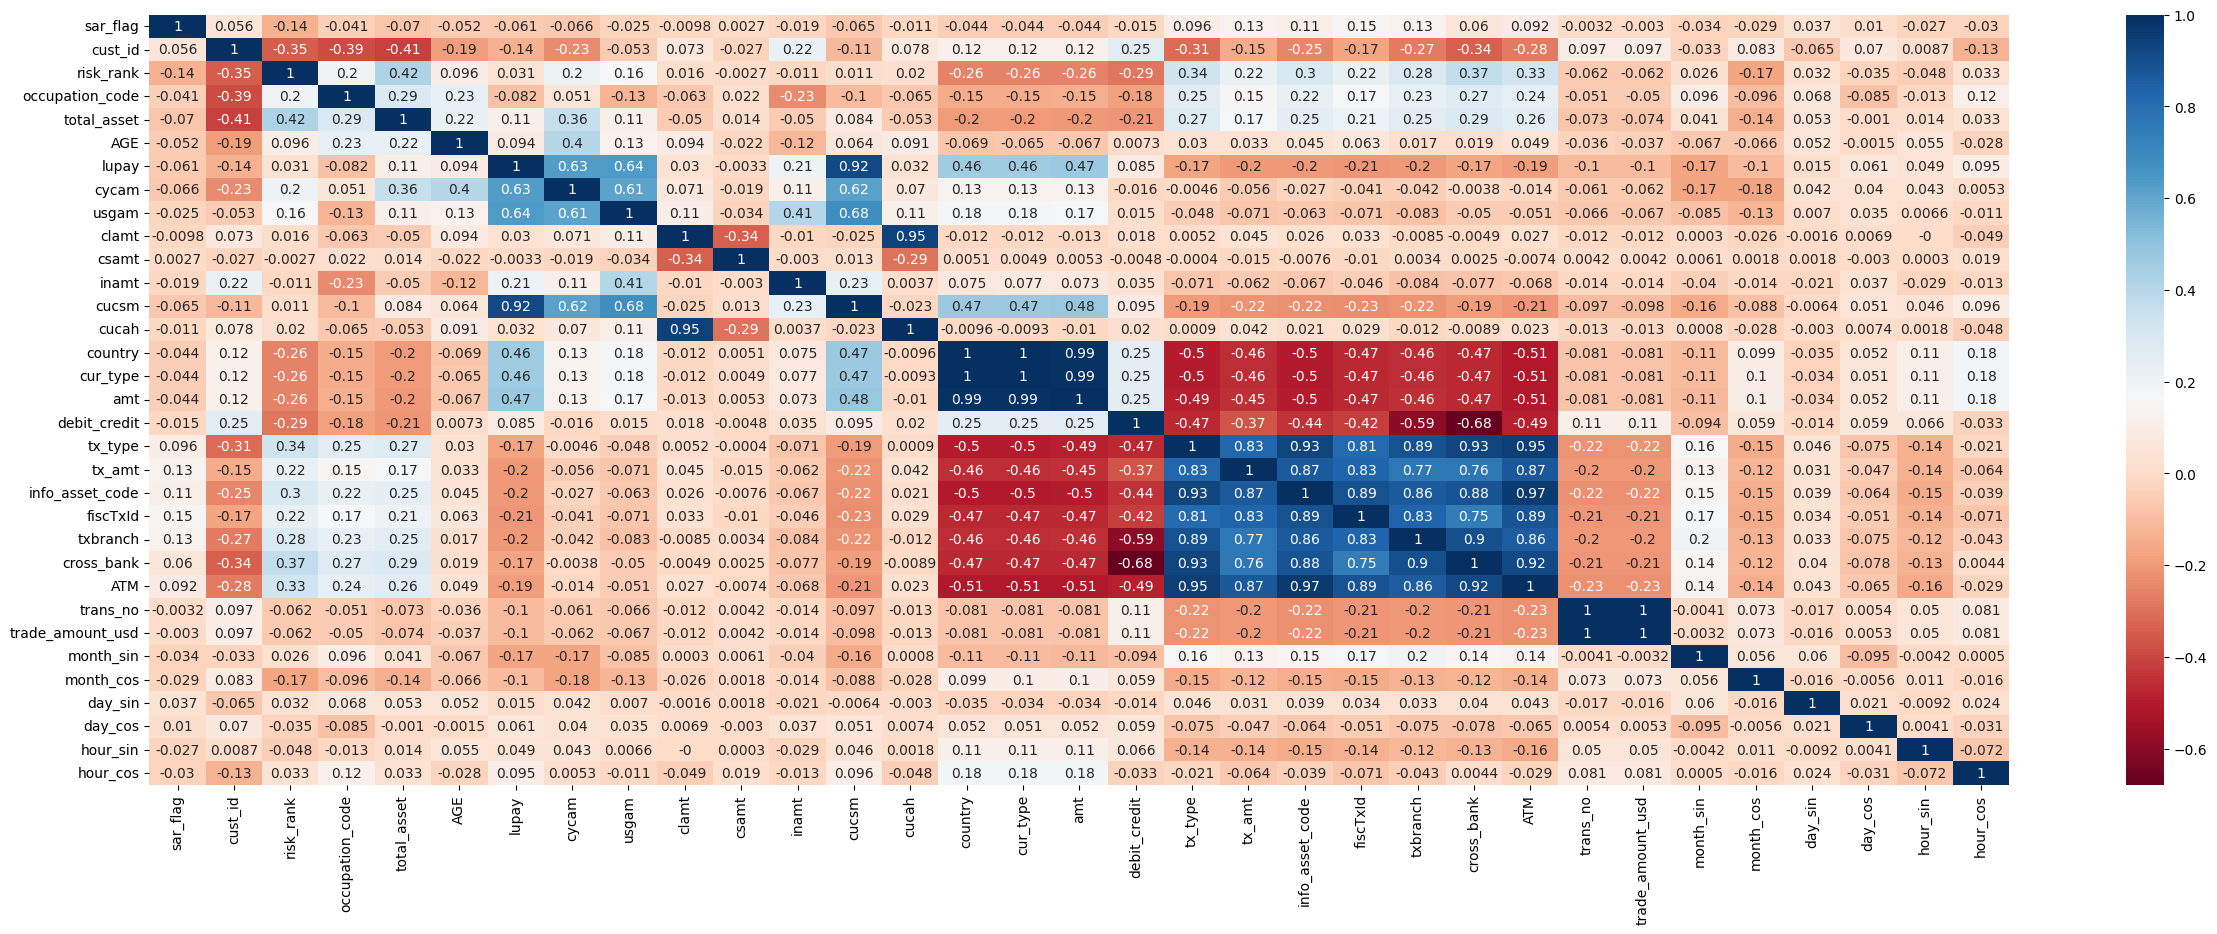

In [23]:
plt.figure(figsize=(30, 10))
corr = df.iloc[:, 2:].corr(method="spearman").round(4)
sns.heatmap(data = corr, annot=True, cmap = 'RdBu', annot_kws = {"fontsize": 10})
plt.show()

In [5]:
train = df[~df["sar_flag"].isnull()]
test = df[df["sar_flag"].isnull()]
print(f"train: {len(train)}, test: {len(test)}")
print(f"alert_key of train: {train['alert_key'].nunique()}, alert_key of test: {test['alert_key'].nunique()}")

train: 136385, test: 15469
alert_key of train: 23906, alert_key of test: 1845


In [6]:
train[target] = train[target].astype(int)

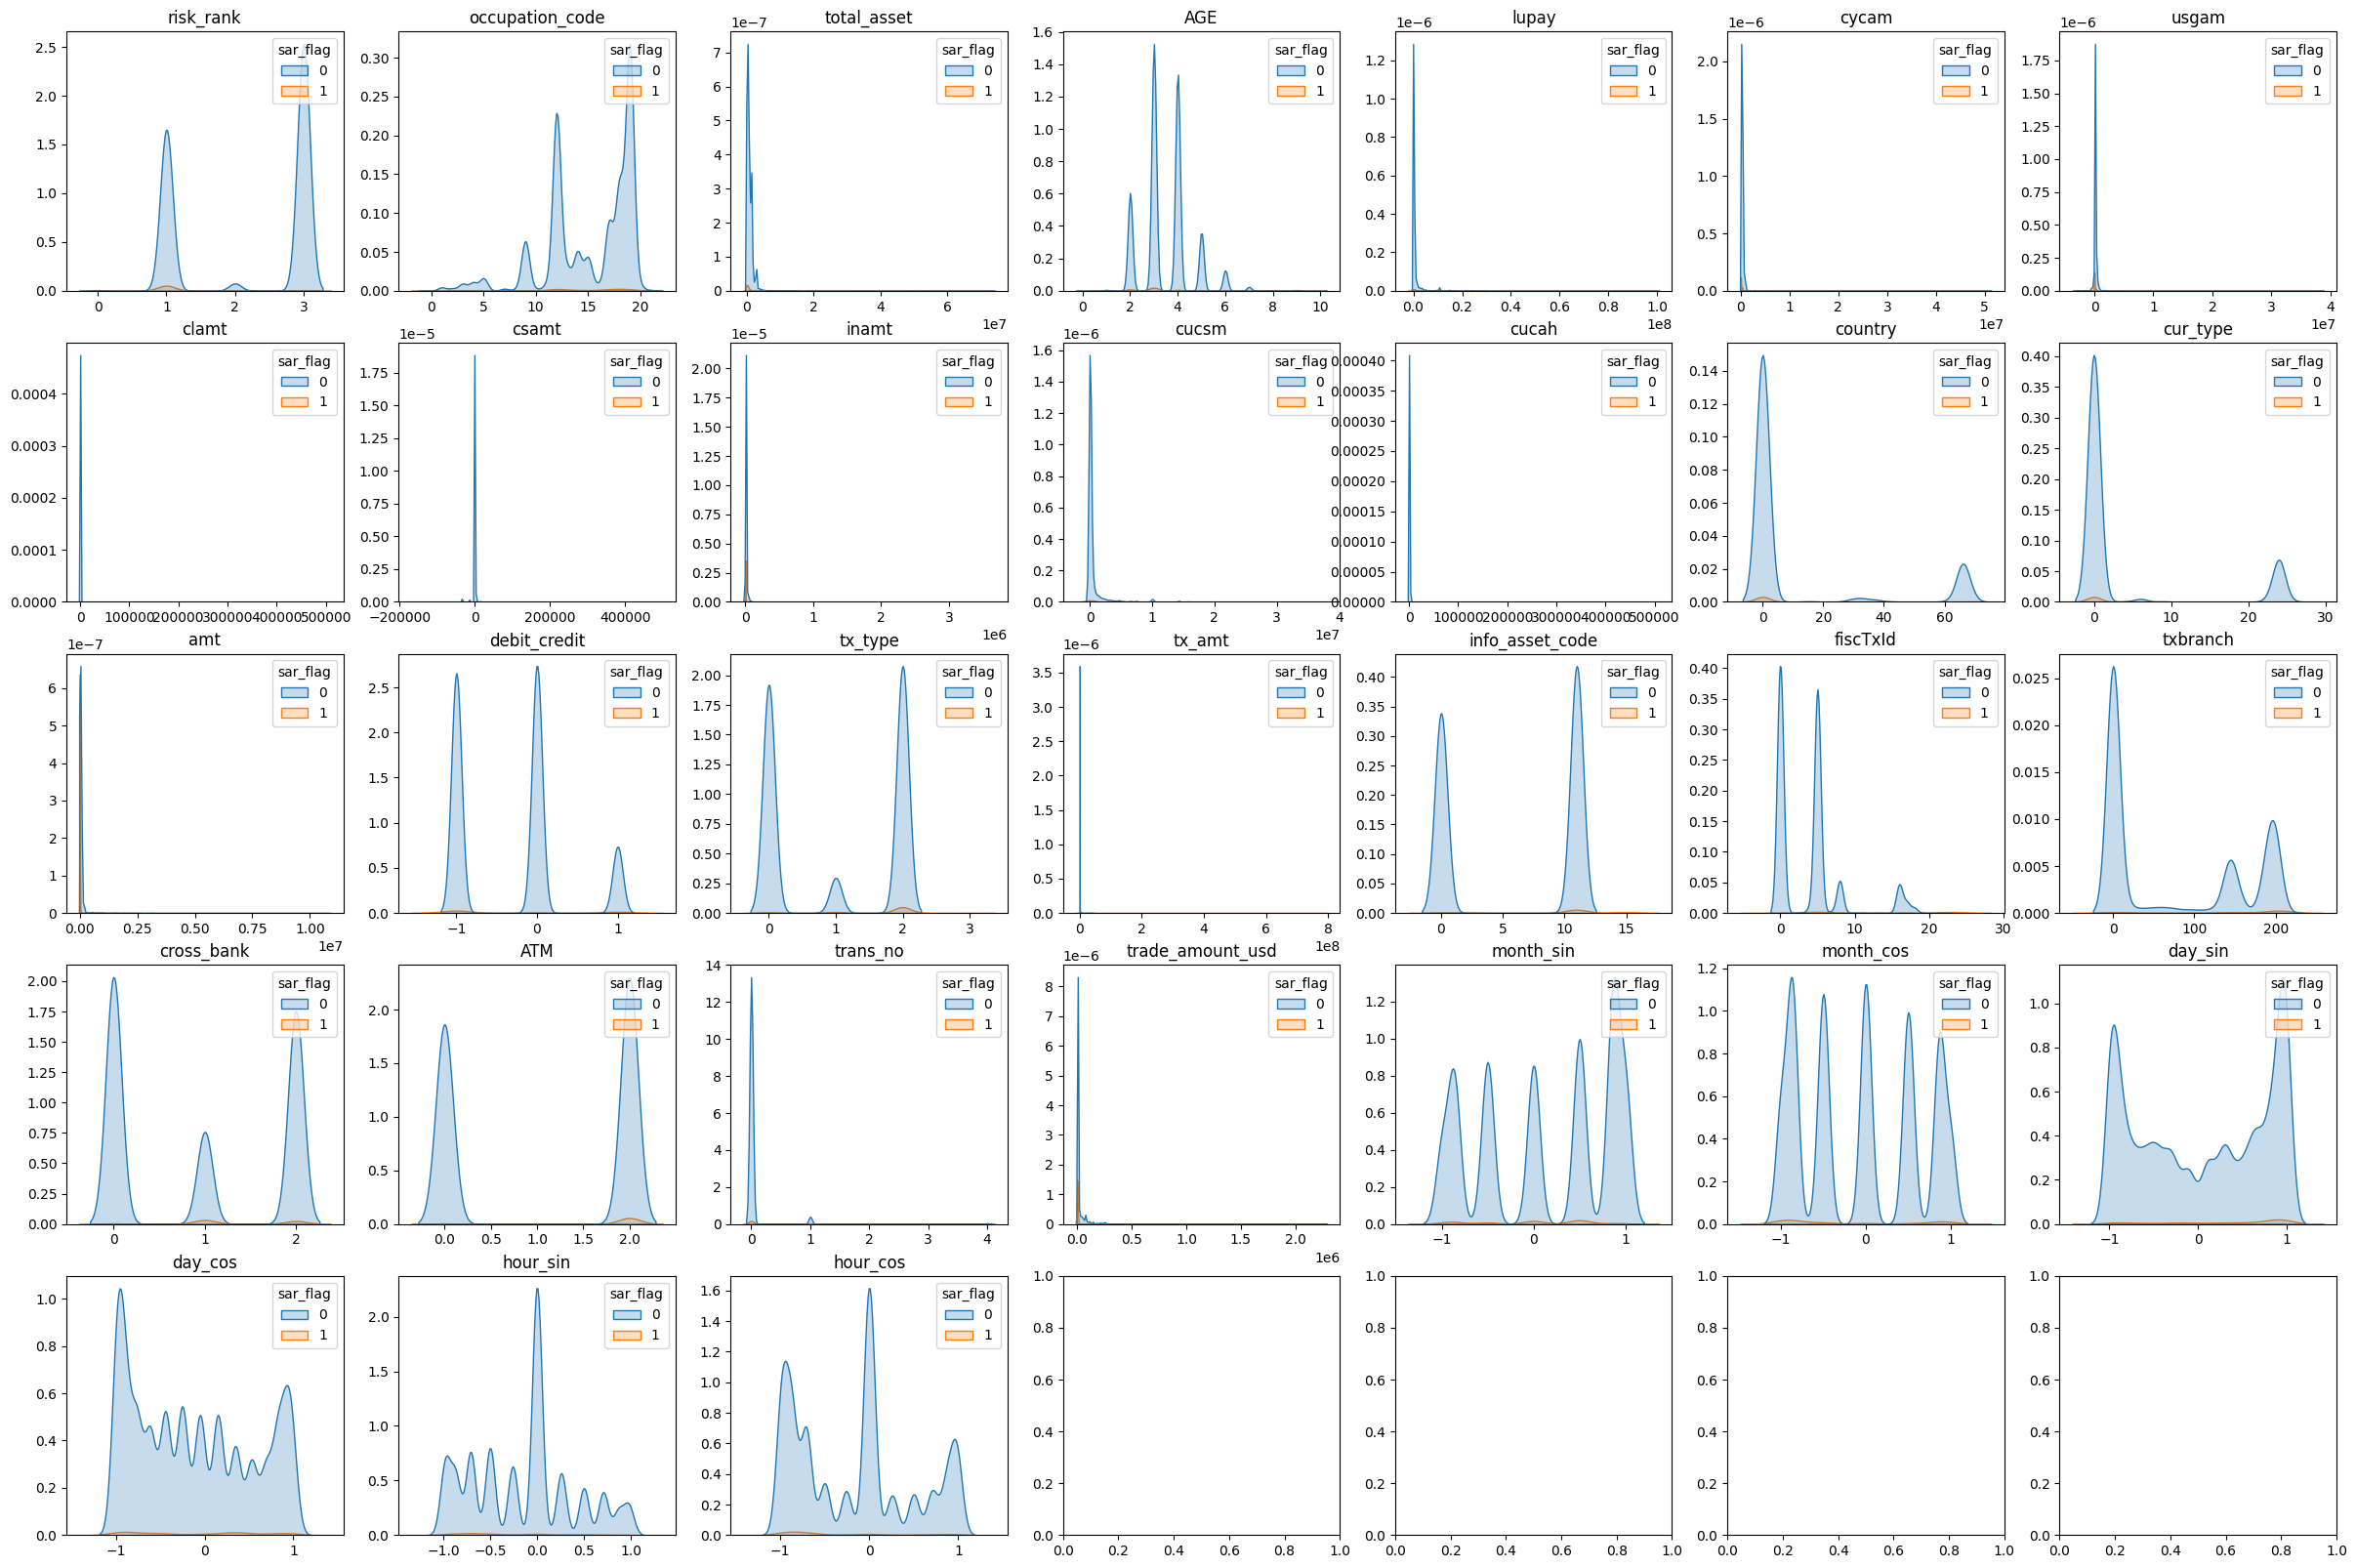

In [26]:
feats = train.columns[4:]
k = 0
a, b = 5, 7
fig, ax = plt.subplots(a, b, figsize = (30, 20))
for i in range(a):
    for j in range(b):
        try:
            sns.kdeplot(data = train, x = feats[k], hue = target, shade=True, ax = ax[i, j])
            ax[i, j].set(ylabel = None, xlabel = None, title = feats[k])
            k += 1
        except:
            continue

### Category Analysis

In [41]:
train.groupby(["ATM", "sar_flag"]).size()
# TODO: 砍掉dp missing value後，非實體ATM交易時，一定是洗錢

ATM  sar_flag
0    0           59815
     1             219
1    1             173
2    0           73883
     1            2295
dtype: int64

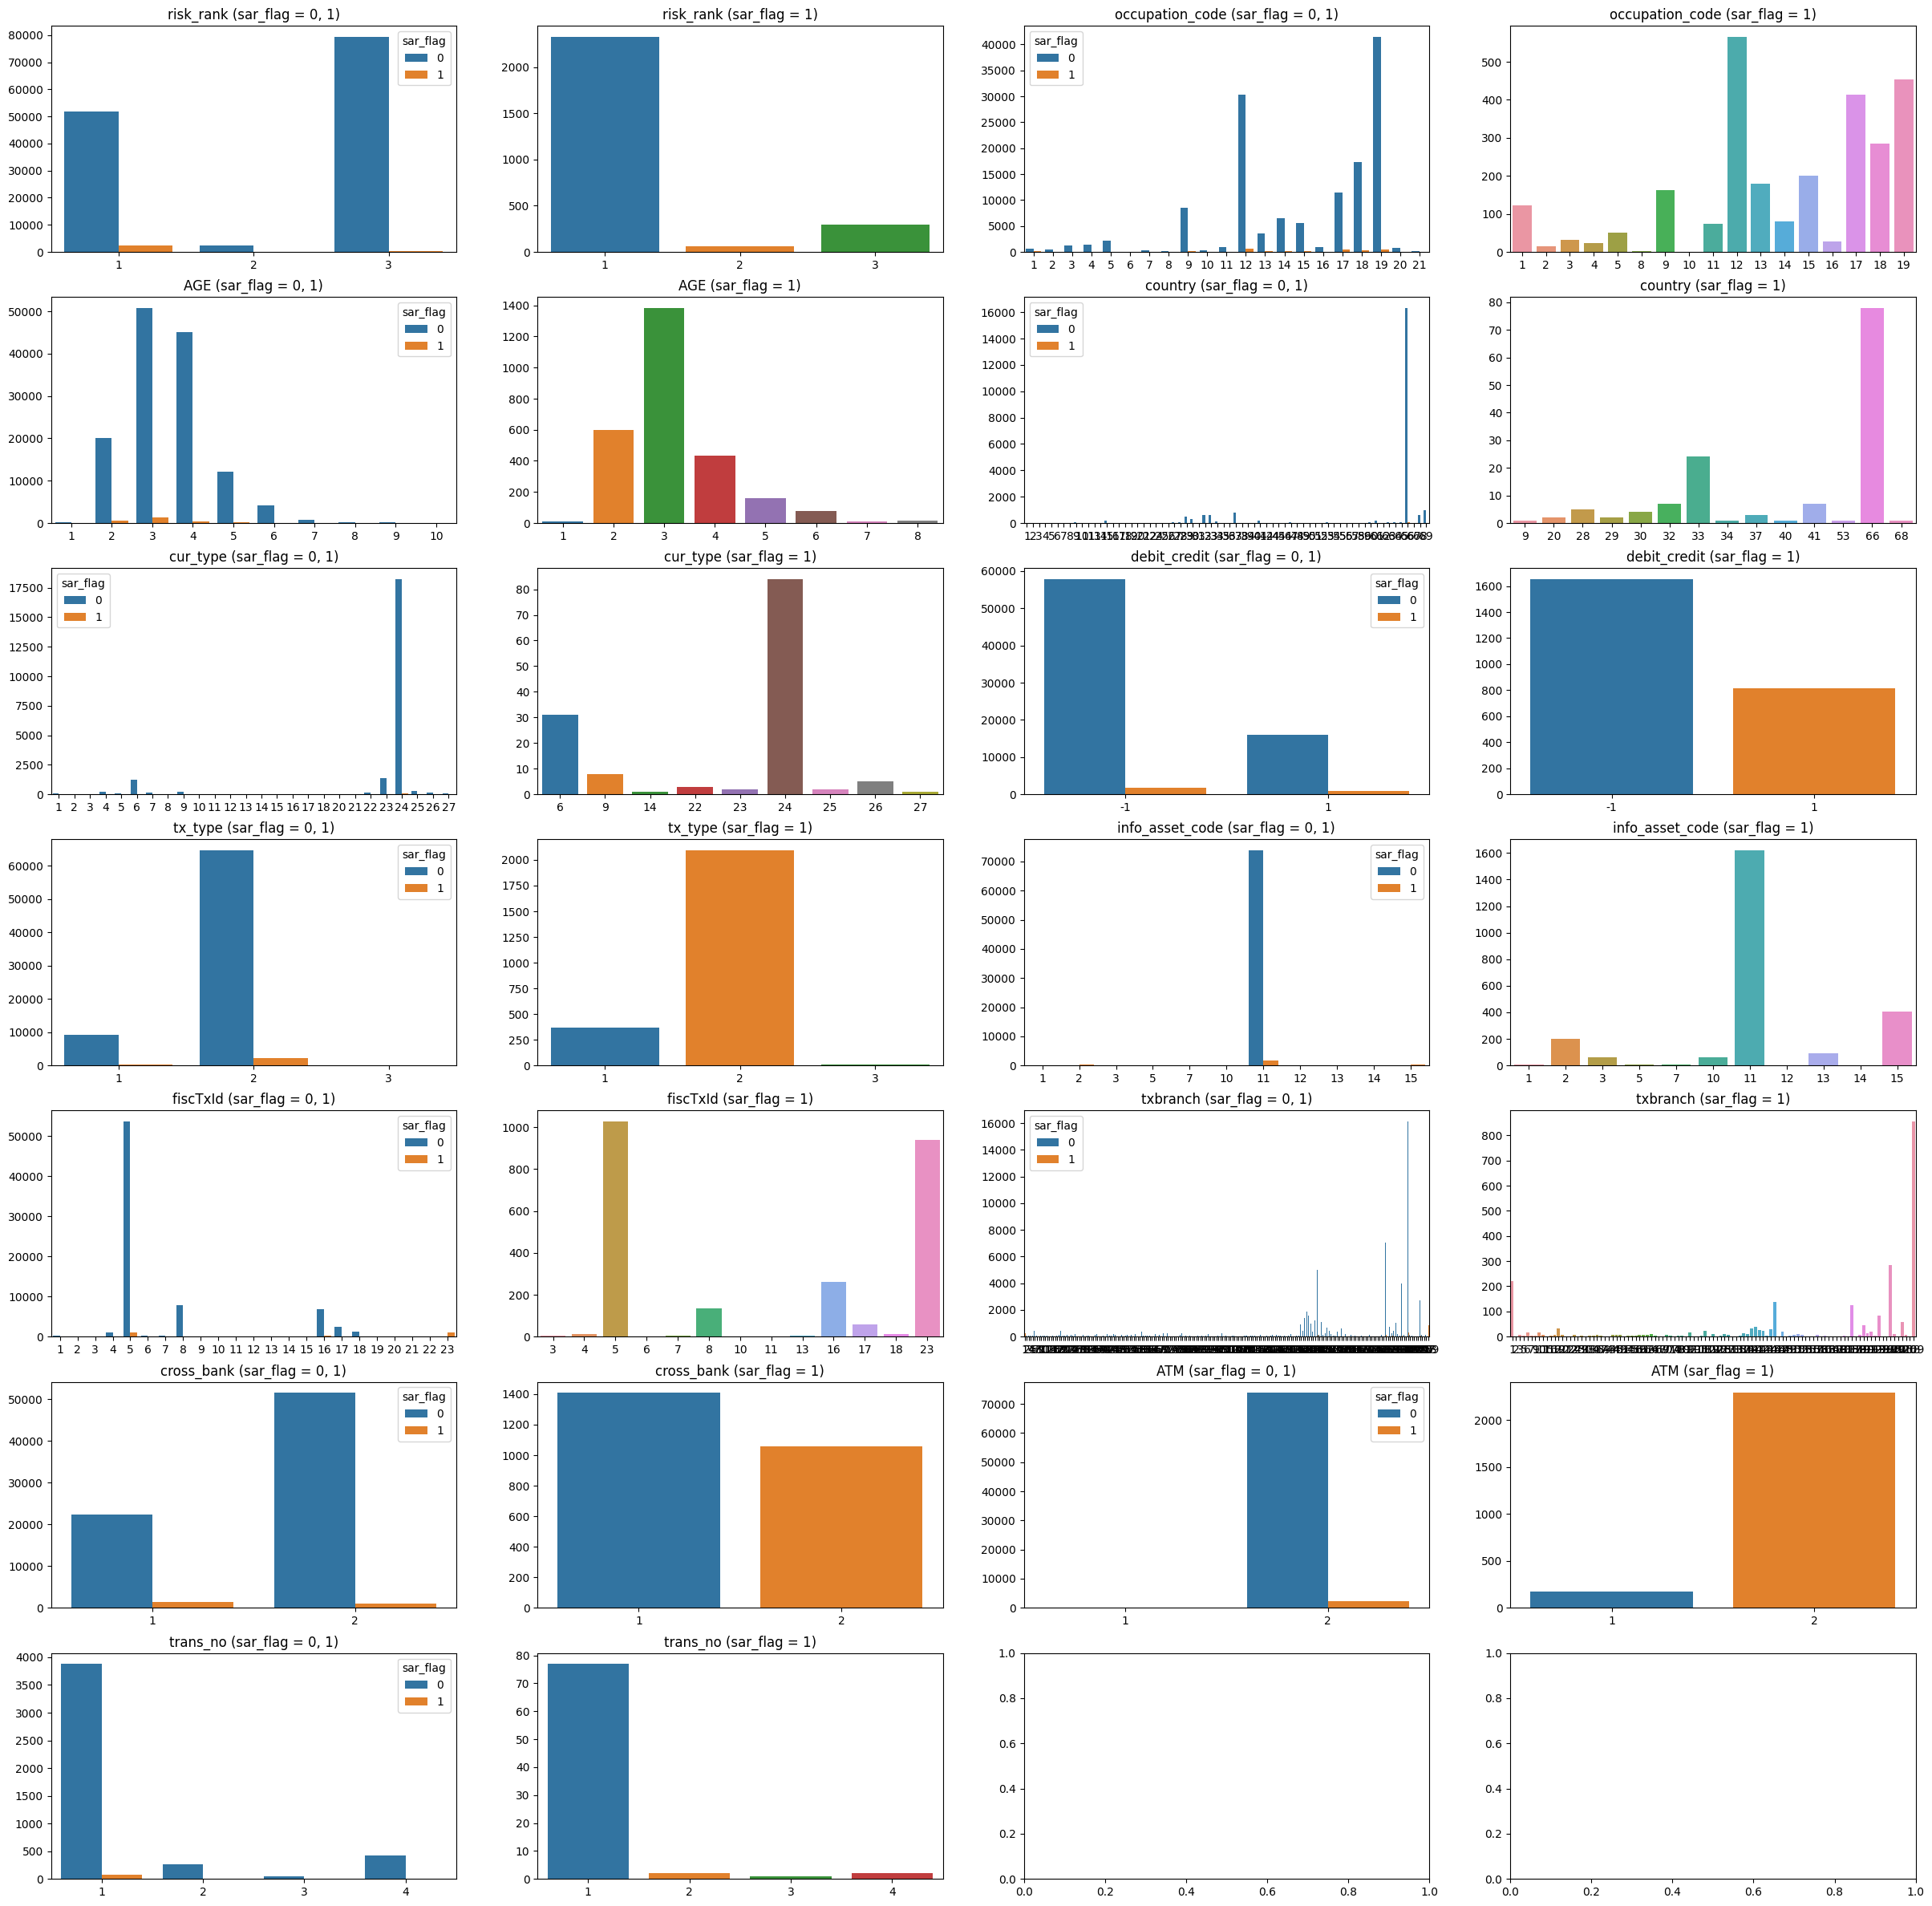

In [27]:
# 各類別變數與y的關係
feats = cat_feats
k = 0
a, b = 7, 4
fig, ax = plt.subplots(a, b, figsize = (30, 30))
for i in range(a):
    for j in range(0, b, 2):
        try:
            data = train[train[feats[k]] != 0]
            sns.countplot(data = data, x = feats[k], hue = target, ax = ax[i, j])
            sns.countplot(data = data.query("sar_flag == 1"), x = feats[k], ax = ax[i, j+1])

            ax[i, j].set(ylabel = None, xlabel = None, title = f"{feats[k]} (sar_flag = 0, 1)")
            ax[i, j + 1].set(ylabel = None, xlabel = None, title = f"{feats[k]} (sar_flag = 1)")
            k += 1
        except:
            continue

fig.savefig("data/image/cat_feats.png")

# TODO: 砍掉dp missing value後，非實體ATM交易時，一定是洗錢

In [28]:
# 沒出現在sar_falg = 1的類別，以-1取代
train1 = train.copy()
for feat in tqdm(cat_feats):
    train2 = train1[[target] + [feat]]
    cat = train2[train2[target] == 1][feat].unique()
    train1[feat] = train1[feat].apply(lambda X: -1 if X not in cat else X)

100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


In [29]:
# 各類別在sar為1或0的個數
df_gbs1 = pd.DataFrame()
for feat in cat_feats:
    df_gb = train1.groupby([feat, target]).size().unstack().dropna()
    df_gb = df_gb.reset_index()
    df_gb.insert(0, "feature", df_gb.columns[0])
    df_gb.columns = ["feat", "type", "count0", "count1"]
    df_gbs1 = pd.concat([df_gbs1, df_gb], ignore_index = True)
df_gbs1.head(3)

,feat,type,count0,count1
0,risk_rank,1,51826.0,2329.0
1,risk_rank,2,2331.0,64.0
2,risk_rank,3,79470.0,294.0


In [30]:
df_gbs1["prob"] = df_gbs1.eval("count1/(count0 + count1)")
df_gbs1 = df_gbs1.sort_values("prob", ascending = False)
df_gbs1.head(3)

,feat,type,count0,count1,prob
127,txbranch,122,16.0,11.0,0.407407
119,txbranch,80,14.0,5.0,0.263158
125,txbranch,110,72.0,24.0,0.250000


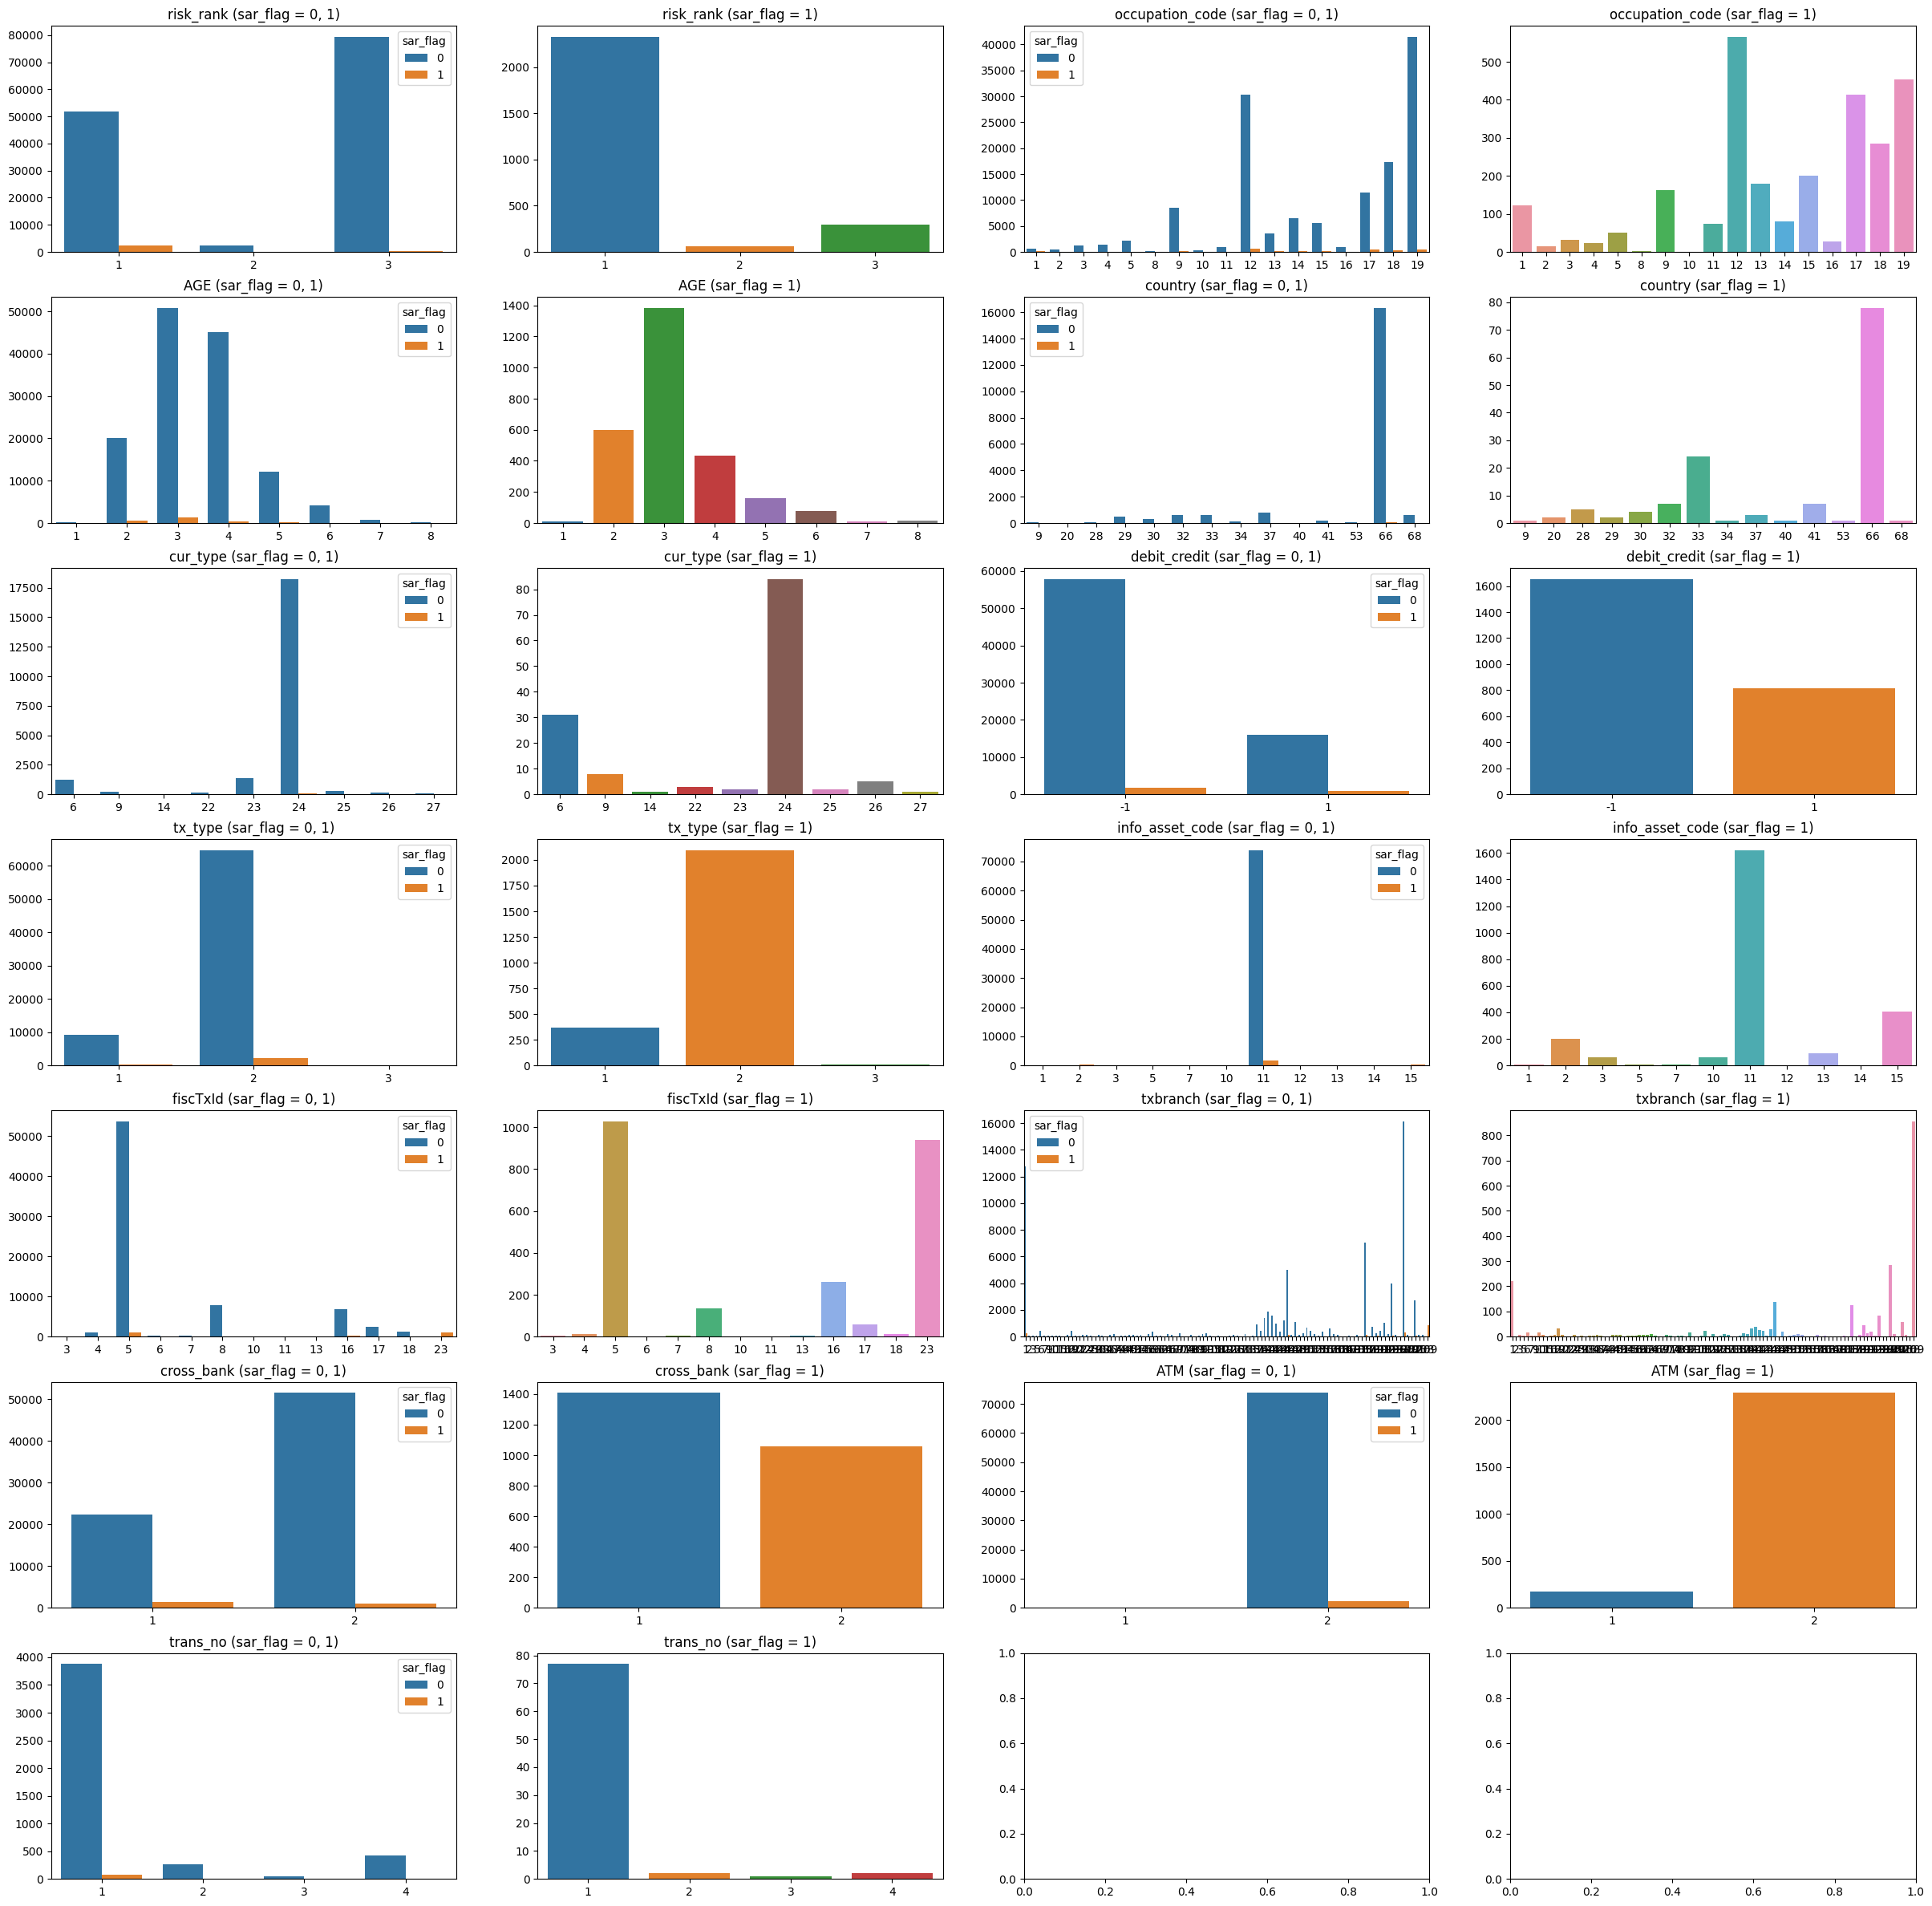

In [31]:
# 各類別變數與y的關係
## 沒出現在sar_falg = 1的類別，以-1取代
feats = cat_feats
k = 0
a, b = 7, 4
fig, ax = plt.subplots(a, b, figsize = (30, 30))
for i in range(a):
    for j in range(0, b, 2):
        try:
            if feats[k] != "debit_credit":
                data = train1[(train1[feats[k]] > 0)]
            else:
                data = train1[(train1[feats[k]] != 0)]

            sns.countplot(data = data, x = feats[k], hue = target, ax = ax[i, j])
            sns.countplot(data = data.query("sar_flag == 1"), x = feats[k], ax = ax[i, j+1])

            ax[i, j].set(ylabel = None, xlabel = None, title = f"{feats[k]} (sar_flag = 0, 1)")
            ax[i, j + 1].set(ylabel = None, xlabel = None, title = f"{feats[k]} (sar_flag = 1)")
            k += 1
        except:
            continue

fig.savefig("data/image/cat_feats_replace.png")

In [32]:
# 類別變數配對組合
pair_cat_feats = []
for i in range(3):
    for j in range(len(cat_feats)):
        if (cat_feats[i] != cat_feats[j]) & (cat_feats[j] != "txbranch"):
            pair = set([cat_feats[i], cat_feats[j]])
            if pair not in pair_cat_feats:
                pair_cat_feats.append(pair)

pair_cat_feats.append(set(['country', 'cur_type']))

for i in range(5, 12):
    for j in range(5, 12):
        if (cat_feats[i] != cat_feats[j]) & (cat_feats[j] != "txbranch") & (cat_feats[i] != "txbranch"):
            pair = set([cat_feats[i], cat_feats[j]])
            if pair not in pair_cat_feats:
                pair_cat_feats.append(pair)


pair_cat_feats = [sorted(i) for i in pair_cat_feats]
pair_cat_feats = sorted(pair_cat_feats, key = lambda X: [list(X)[0], list(X)[1]])

len(pair_cat_feats)

46

In [ ]:
# 兩兩類別變數與y的關係
df_gbs = pd.DataFrame()
feats = pair_cat_feats
k = 0
a, b = 23, 4
fig, ax = plt.subplots(a, b, figsize = (30, 160))
for i in range(a):
    for j in range(0, b, 2):
        try:
            feat = list(feats[k])
            
            train1 = train.copy()
            train1 = train1[(train1[feat[0]] != 0) & (train1[feat[1]] != 0)]

            df_gb = train1.groupby([feat[0], feat[1], target]).size().unstack()
            df_gb = df_gb.dropna()

            df_gb.plot(kind = "bar", ax = ax[i, j])
            df_gb[1].plot(kind = "bar", ax = ax[i, j+1], color = "#ff7f0e")

            ax[i, j].set(ylabel = f"{i}, {j}", xlabel = None, title = f"{feat[0]} & {feat[1]} (sar_flag = 0, 1)")
            ax[i, j + 1].set(ylabel = f"{i}, {j+1}", xlabel = None, title = f"{feat[0]} & {feat[1]} (sar_flag = 1)")
            
            
            df_gb = df_gb.reset_index()
            col = df_gb.columns
            df_gb.insert(0, "cat1", col[0])
            df_gb.insert(2, "cat2", col[1])
            df_gb.columns = ["cat1", "cat_type1", "cat2", "cat_type2", "count0", "count1"]
            
            df_gb["prop1"] = df_gb["count1"]/df_gb["count1"].sum()
            df_gb["prop1_0"] = df_gb["count1"] / (df_gb["count0"] + df_gb["count1"])

            df_gb["row, col"] = f"{i}, {j}"
            df_gbs = pd.concat([df_gbs, df_gb], ignore_index = True)

            k += 1
        except:
            continue
        
fig.savefig("data/image/pair_cat_feats.png")

In [34]:
df_gbs1 = df_gbs.sort_values(["prop1_0", "prop1"], ascending = False)
df_gbs1.head()

,cat1,cat_type1,cat2,cat_type2,count0,count1,prop1,prop1_0,"row, col"
321,cross_bank,1,occupation_code,1,13.0,83.0,0.033630,0.864583,"12, 0"
114,AGE,1,occupation_code,13,2.0,11.0,0.004094,0.846154,"3, 2"
19,AGE,4,country,28,1.0,5.0,0.037037,0.833333,"0, 2"
426,debit_credit,1,occupation_code,1,19.0,47.0,0.019044,0.712121,"15, 2"
264,country,30,occupation_code,14,1.0,2.0,0.014925,0.666667,"9, 2"


### Numerical Analysis

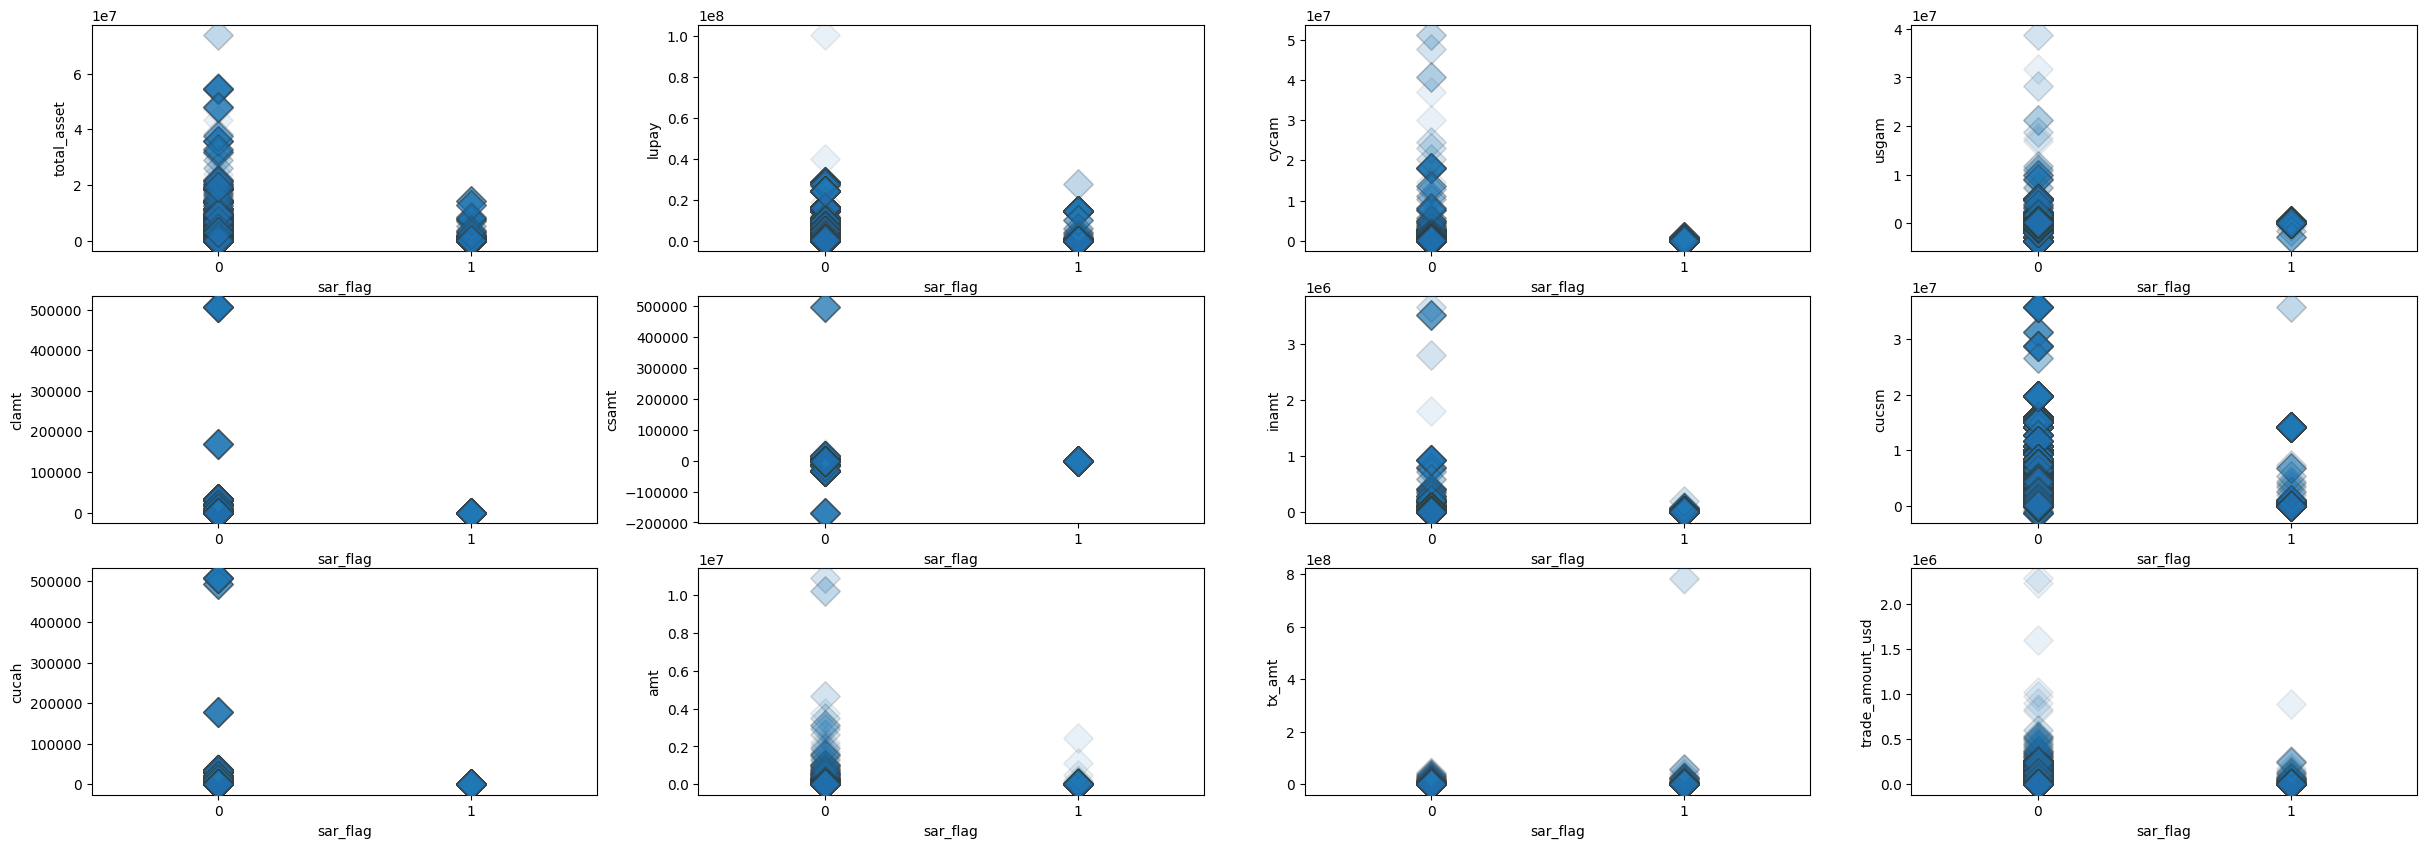

In [35]:
# 各連續變數與y的關係
feats = num_feats
k = 0
a, b = 3, 4
fig, ax = plt.subplots(a, b, figsize = (30, 10))
for i in range(a):
    for j in range(b):
        try:
            sns.stripplot(
                data = train, x = target, y = feats[k],
                jitter = False, s = 15, marker = "D", linewidth = 1, alpha = 0.1, ax = ax[i, j]
            )
            k += 1
        except:
            continue

fig.savefig("data/image/num_feats.png")

In [36]:
train1 = train.sort_values(target)

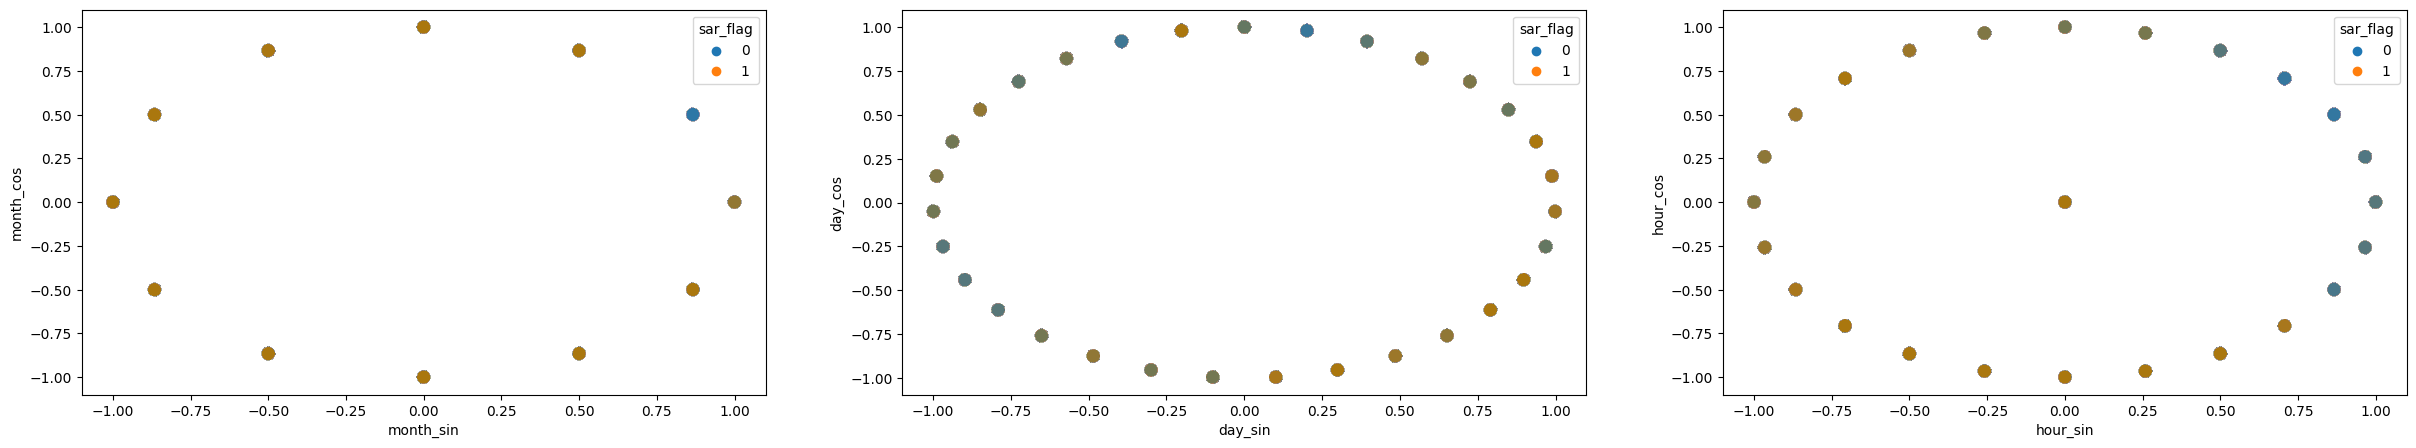

In [37]:
# 各循環變數與y的關係
k = 0
a, b = 1, 3
fig, ax = plt.subplots(a, b, figsize = (30, 5))
for j in range(b):
    sns.scatterplot(data = train1, x = cycle_feats[j*2], y = cycle_feats[j*2+1], hue = target, alpha = 0.01, s = 100, ax = ax[j])

fig.savefig("data/image/cycle_feats.png")

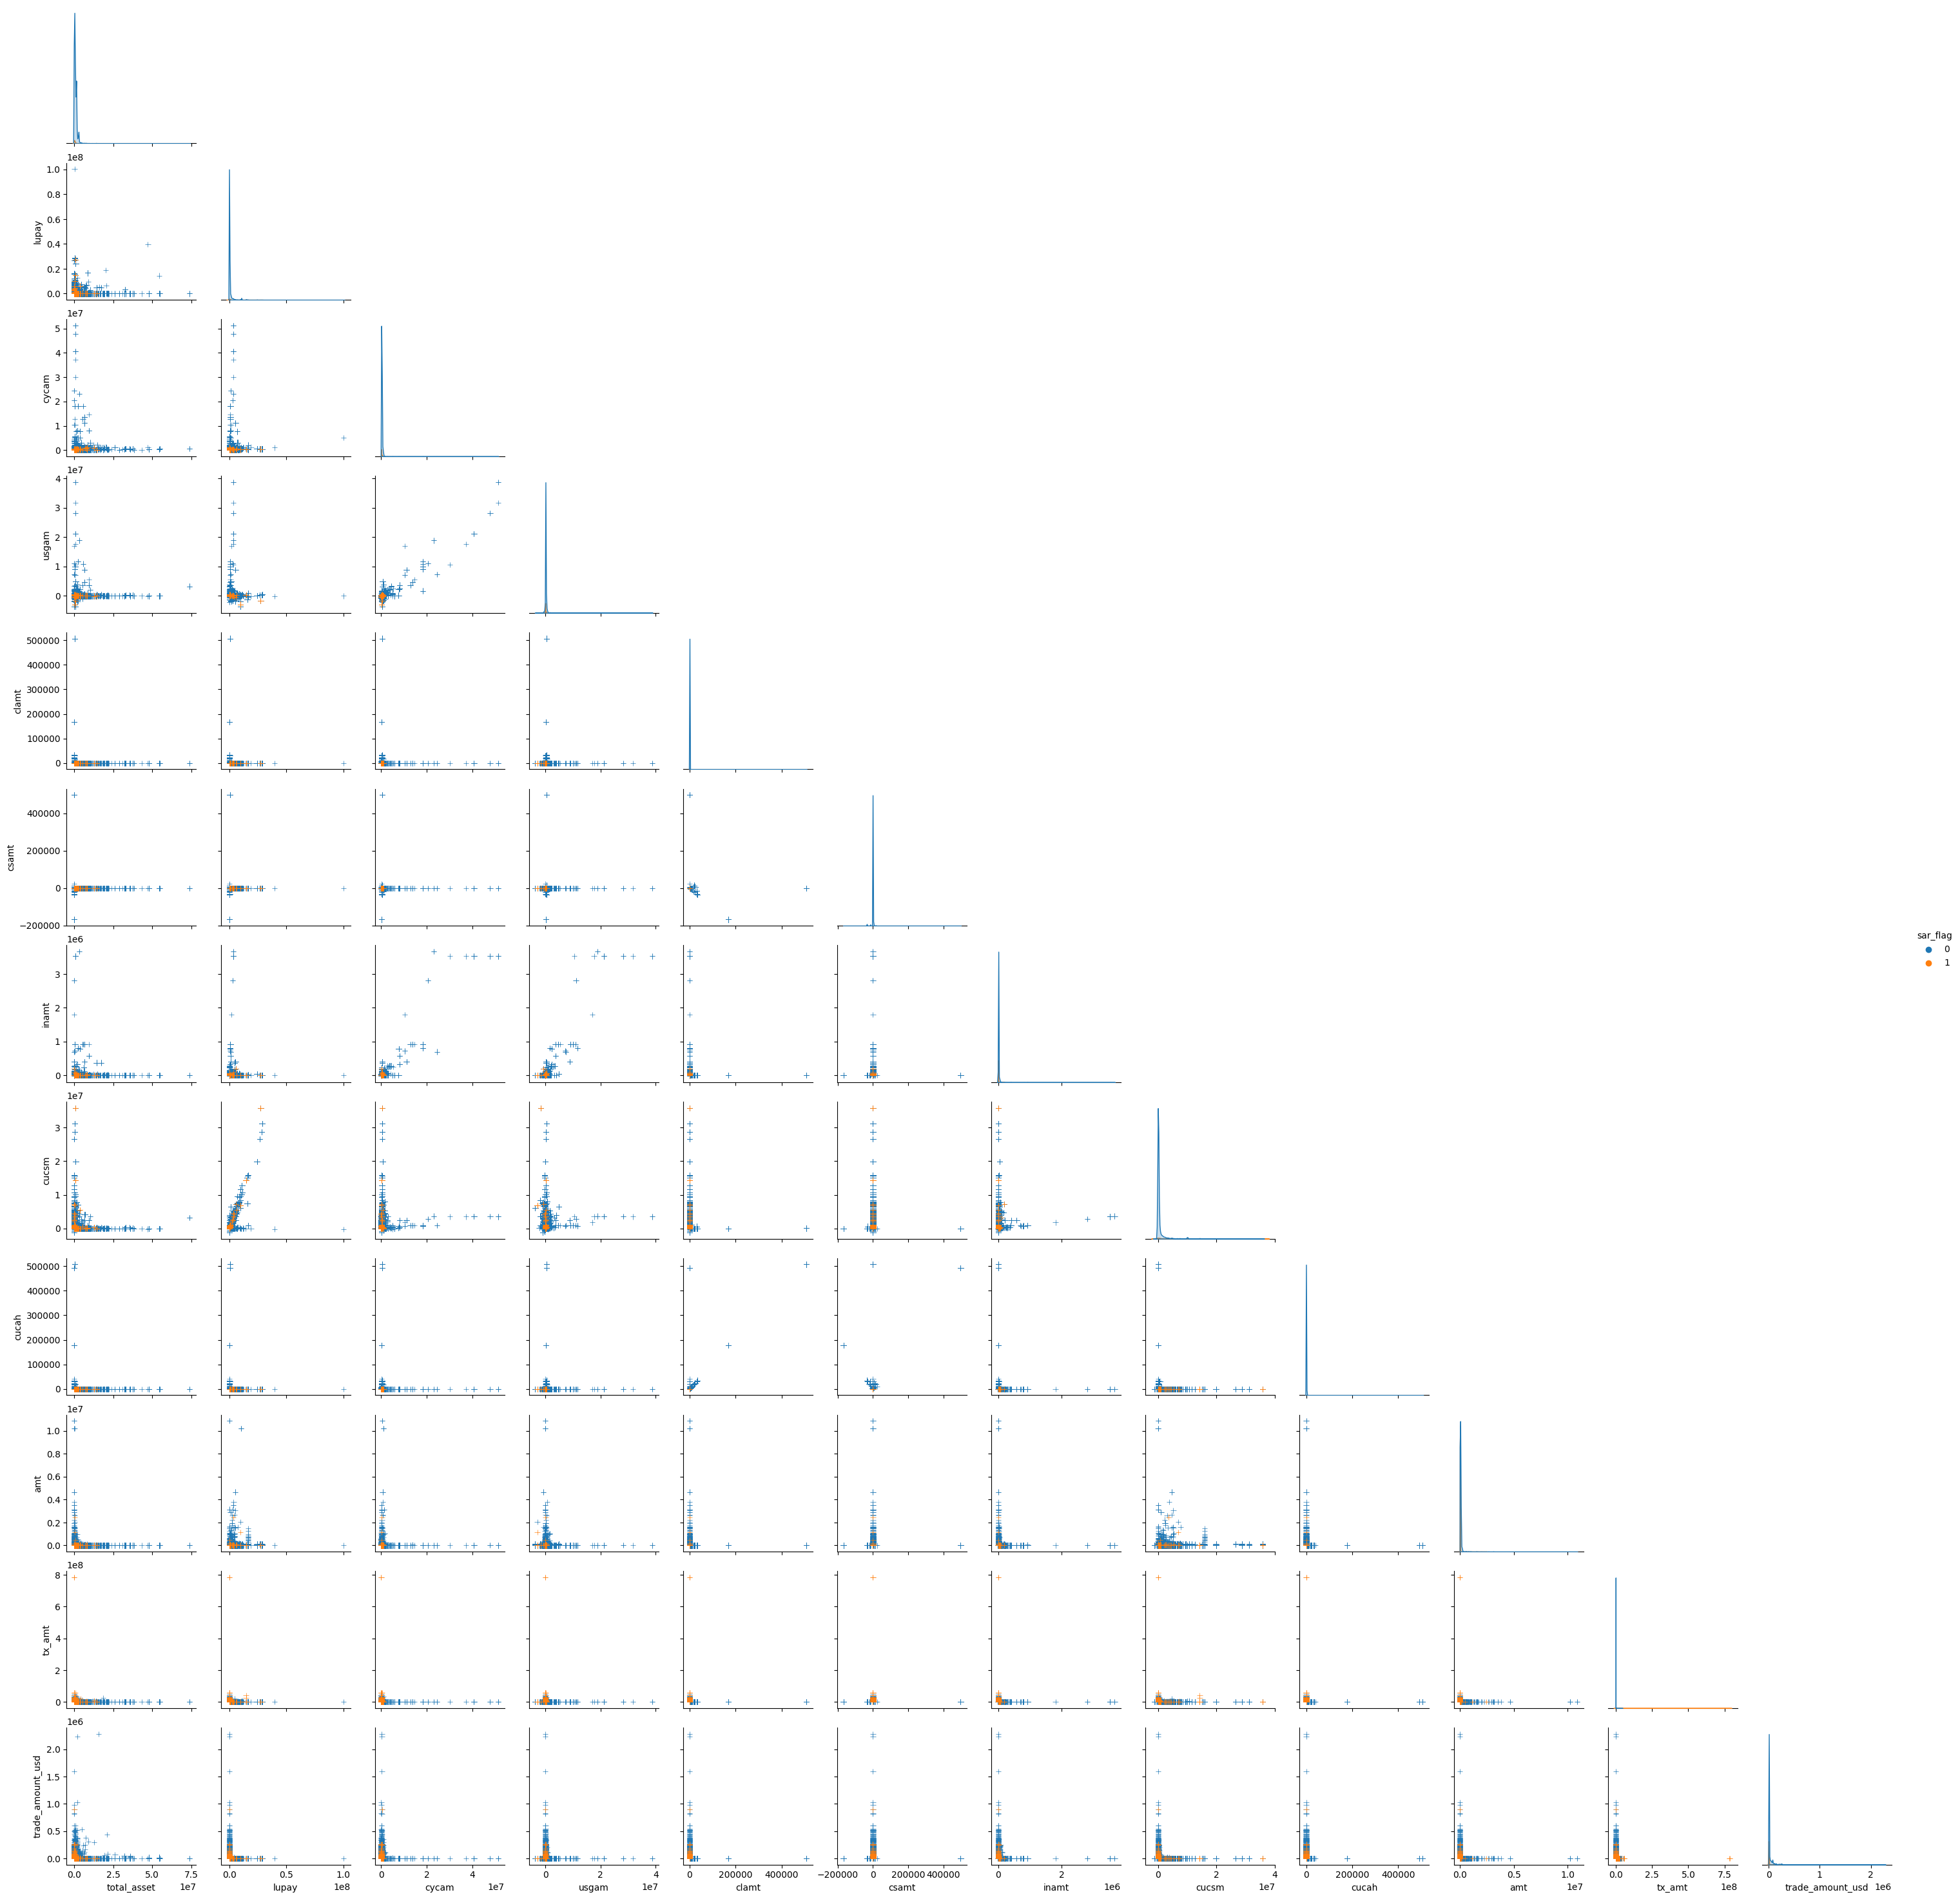

In [38]:
# 兩兩連續變數與y的關係
sns.pairplot(train1[num_feats + [target]], hue = target, markers = "+", corner = True)
plt.savefig("data/image/pairplot.png")

In [39]:
des1 = train1[train1[target] == 1][num_feats].describe()
des1 = des1.loc[["min", "max"]]
des1 = des1.to_dict()

print(f"init: {len(train1)}")
for feat in num_feats:
    train1 = train1[(train1[feat] >= des1[feat]["min"]) & (train1[feat] <=  des1[feat]["max"])]
    print(f"{feat}: {len(train1)}")

init: 136385
total_asset: 136136
lupay: 136096
cycam: 135115
usgam: 133741
clamt: 133091
csamt: 133085
inamt: 132997
cucsm: 132395
cucah: 132327
amt: 132312
tx_amt: 132310
trade_amount_usd: 132305


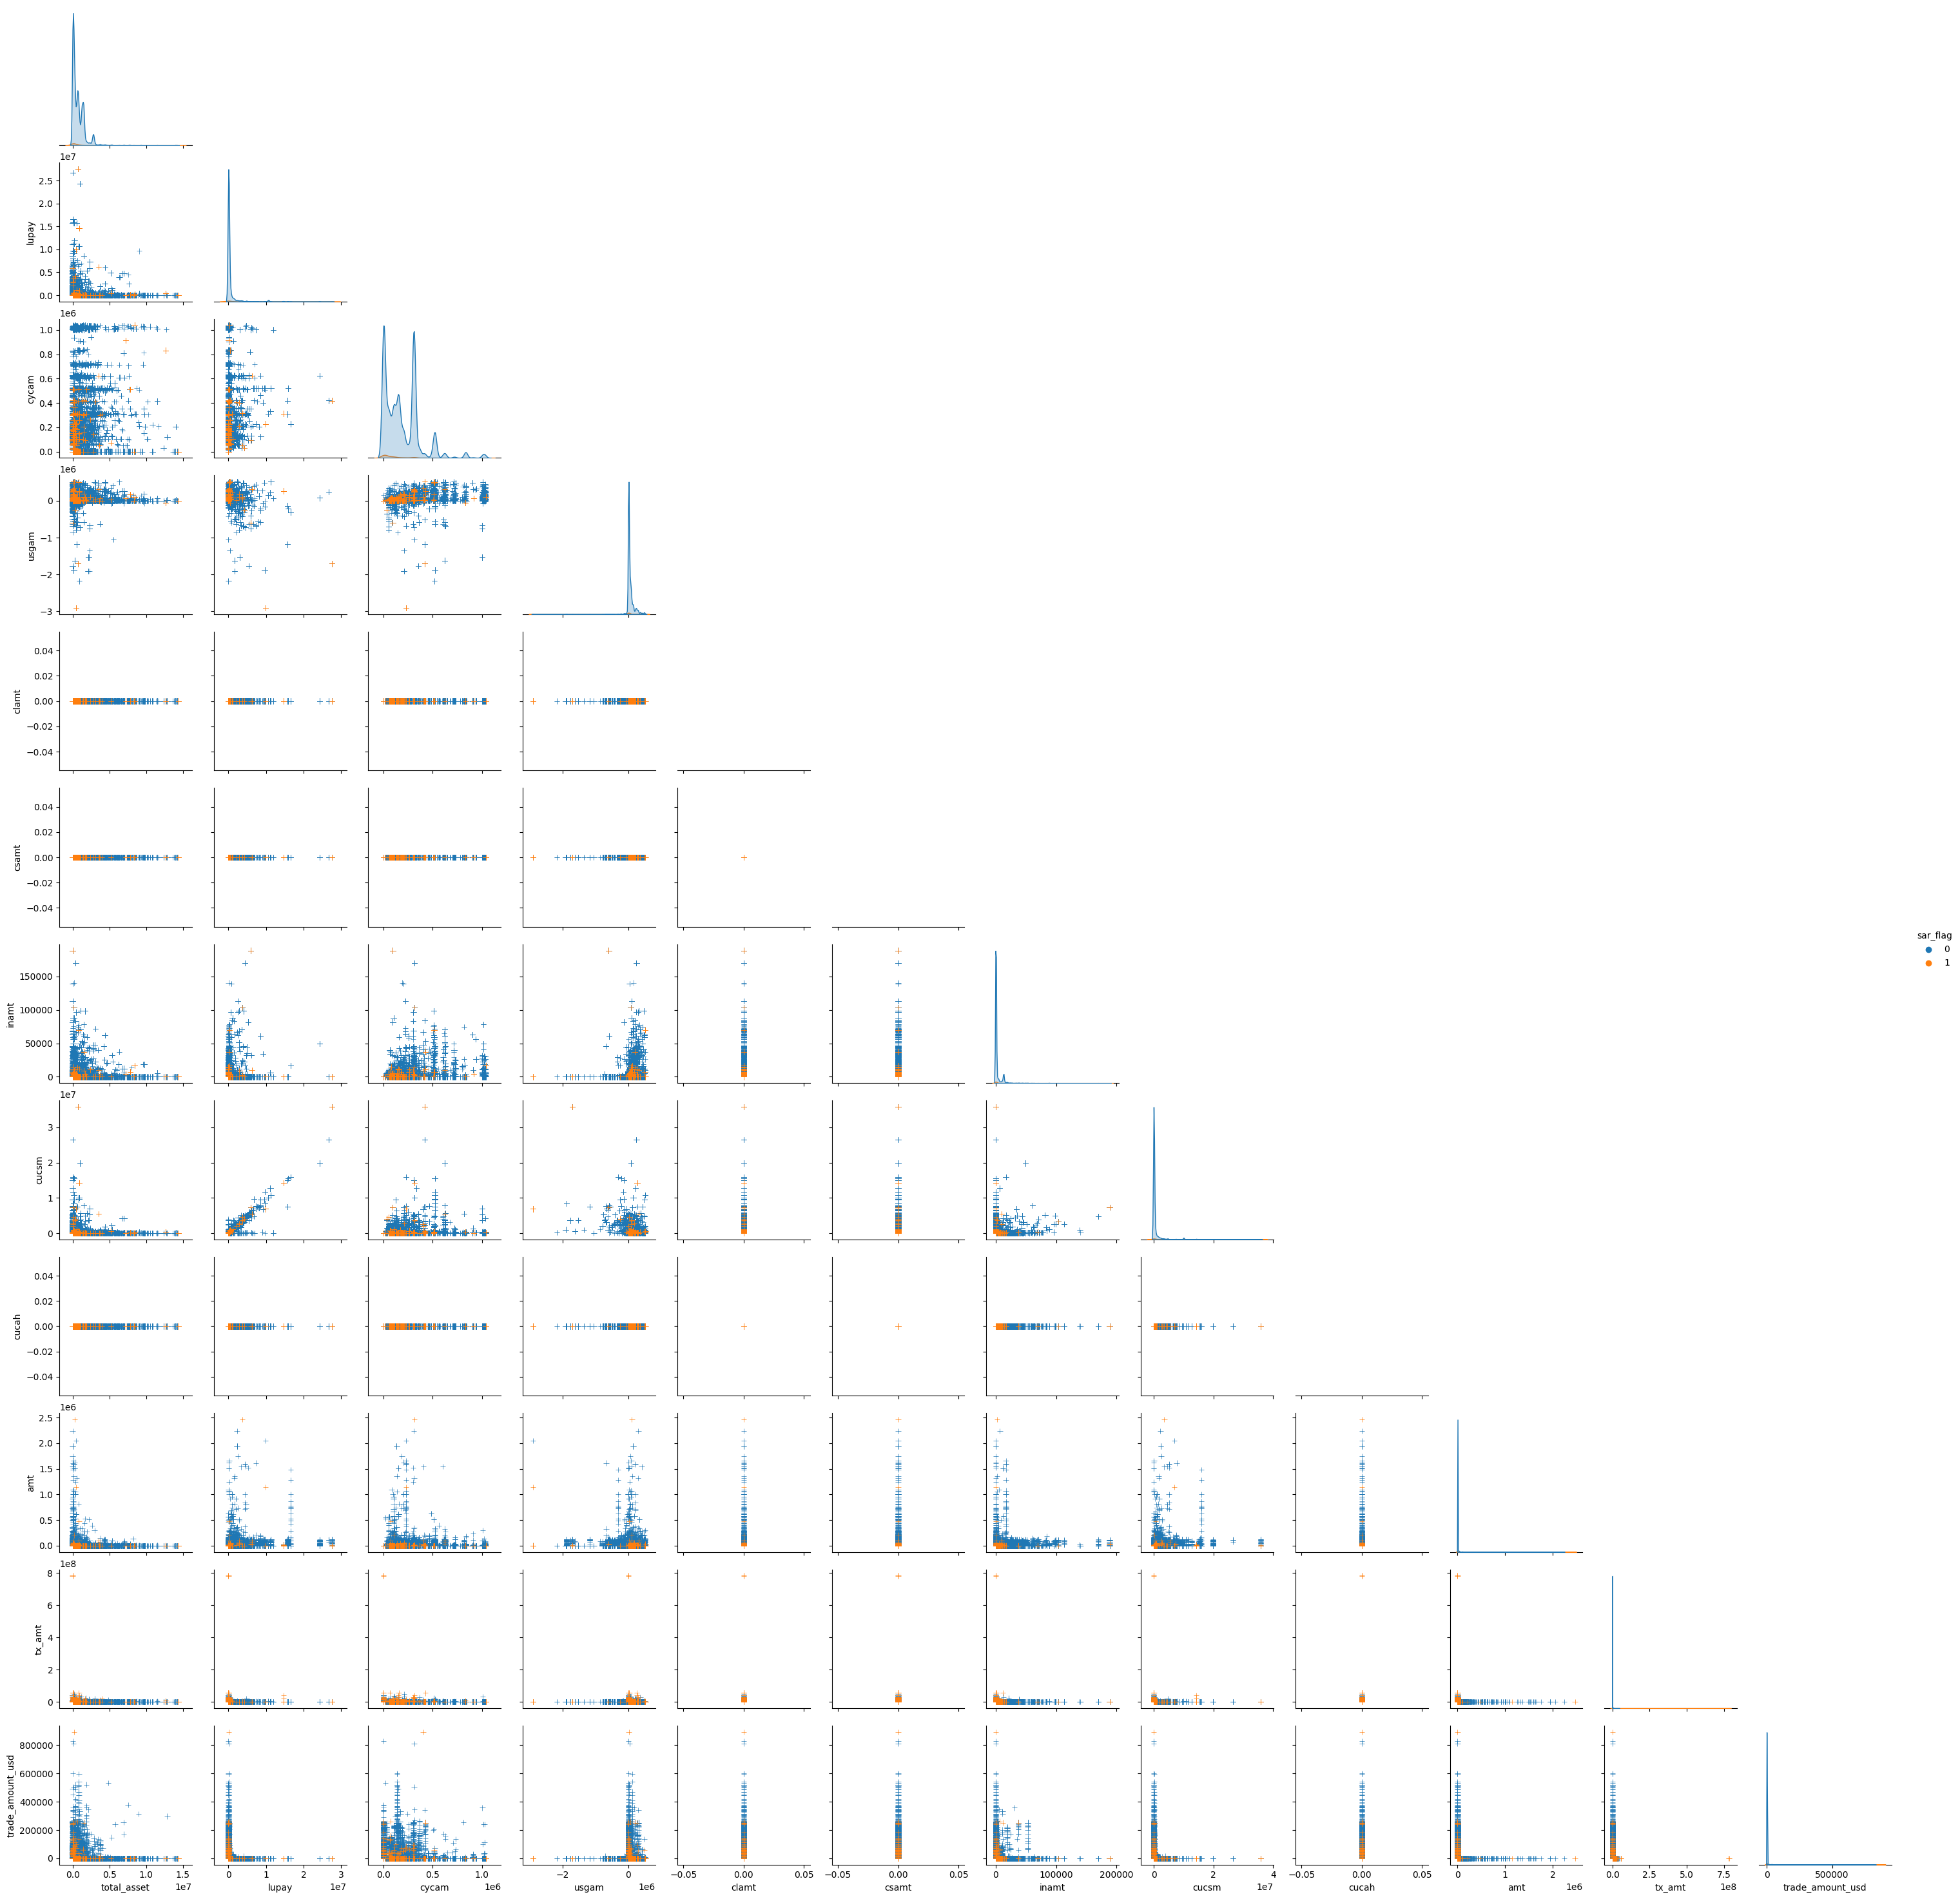

In [40]:
# 兩兩連續變數與y的關係 (刪除超出sar為1的最大/小值之)
sns.pairplot(train1[num_feats + [target]], hue = target, markers = "+", corner = True)

plt.savefig("data/image/pairplot1.png")

In [10]:
ccba = train[['alert_key', 'sar_flag', 'lupay', 'cycam', 'usgam', 'clamt', 'csamt', 'inamt', 'cucsm', 'cucah']].drop_duplicates()
ccba["lupay1"] = ccba["usgam"]/ccba["lupay"]
ccba["usgam1"] = ccba["usgam"]/ccba["cycam"]
ccba["clamt1"] = ccba["clamt"]/ccba["cycam"]
ccba["csamt1"] = ccba["csamt"]/ccba["cycam"]
ccba["inamt1"] = ccba["inamt"]/ccba["cycam"]
ccba["cucsm1"] = ccba["cucsm"]/ccba["cycam"]
ccba["cucah1"] = ccba["cucah"]/ccba["cycam"]
ccba.head(3)

,alert_key,sar_flag,lupay,cycam,usgam,clamt,csamt,inamt,cucsm,cucah,lupay1,usgam1,clamt1,csamt1,inamt1,cucsm1,cucah1
0,171142,0,12565.0,150744.0,82748.0,0.0,0.0,12477.0,12477.0,0.0,6.585595,0.548931,0.0,0.0,0.082769,0.082769,0.0
29,171152,0,3581.0,324783.0,64363.0,0.0,0.0,0.0,4981.0,0.0,17.973471,0.198172,0.0,0.0,0.000000,0.015336,0.0
31,171177,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


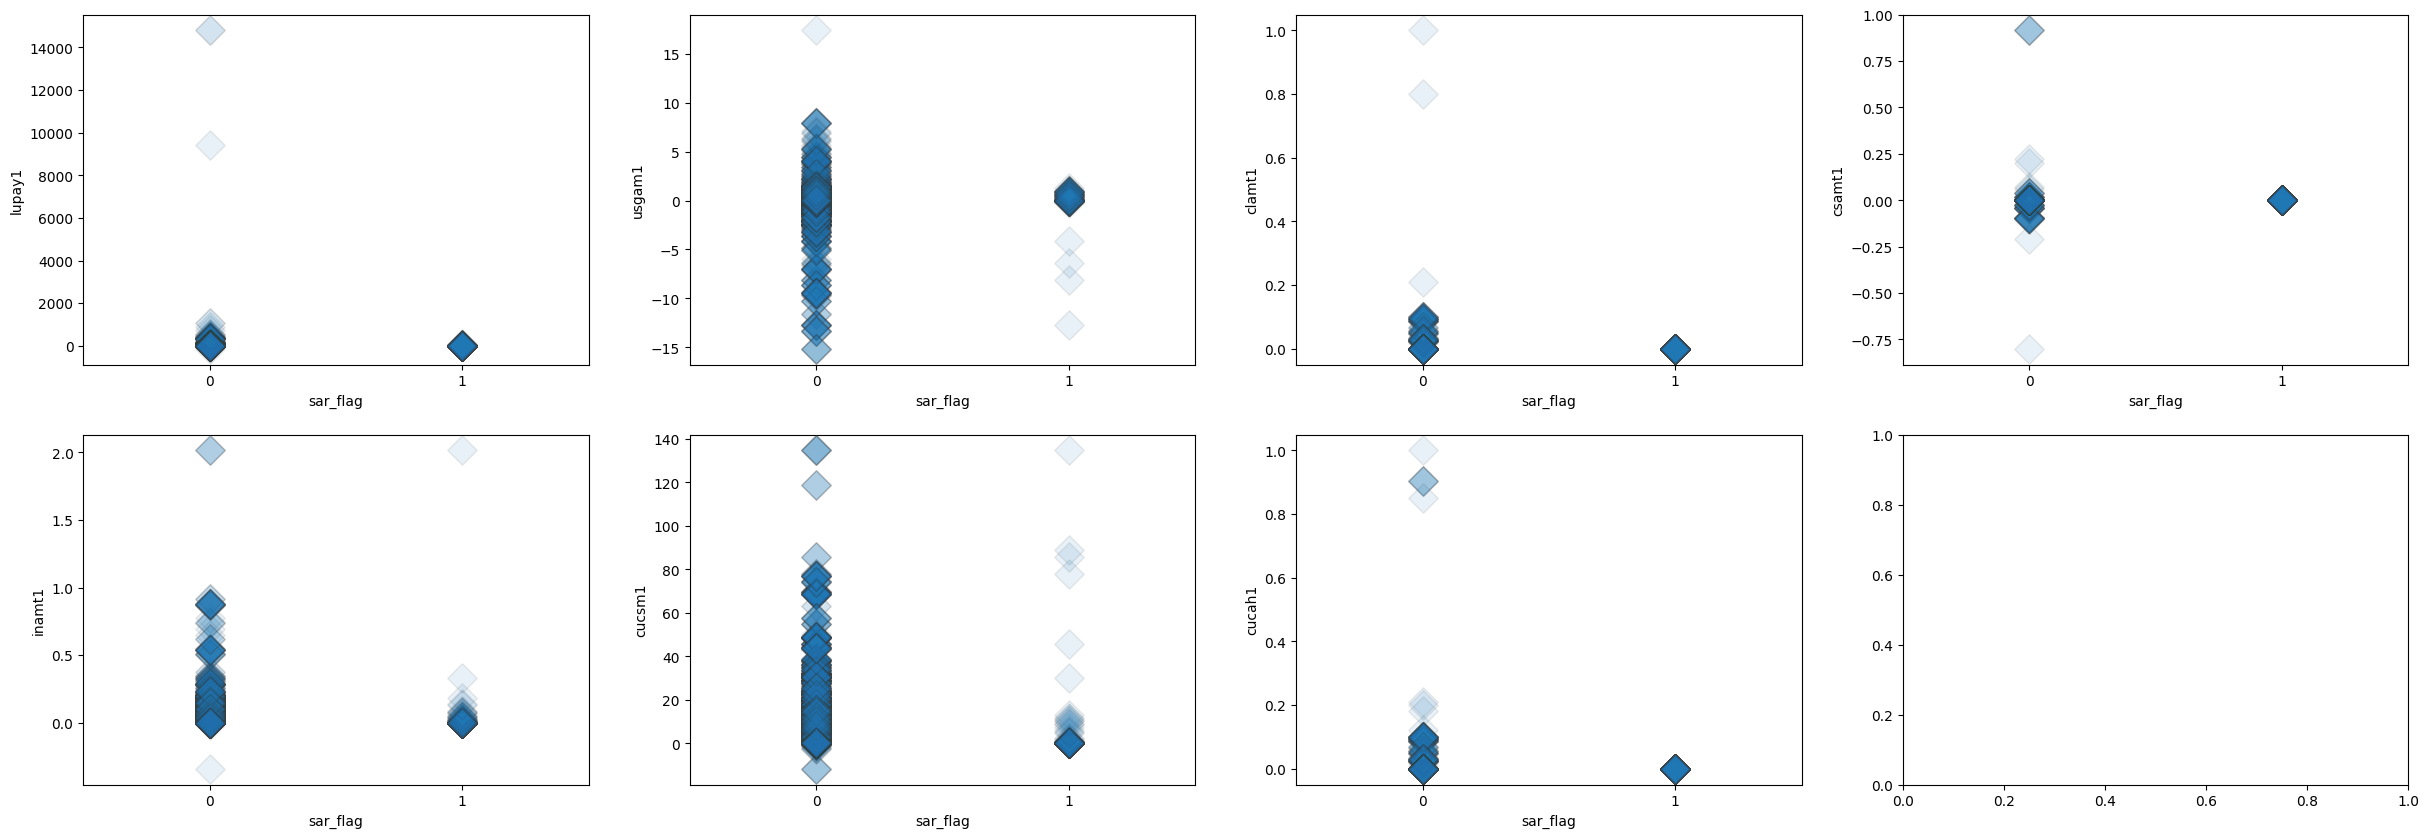

In [15]:
# 各連續變數與y的關係
feats = ccba.columns[-7:]
k = 0
a, b = 2, 4
fig, ax = plt.subplots(a, b, figsize = (30, 10))
for i in range(a):
    for j in range(b):
        try:
            sns.stripplot(
                data = ccba, x = target, y = feats[k],
                jitter = False, s = 15, marker = "D", linewidth = 1, alpha = 0.1, ax = ax[i, j]
            )
            k += 1
        except:
            continue